# Progressive Curriculum (Resolution Based) & KD

We designed a unified pipeline to train a compact ViT on CIFAR‑10 with minimal overhead:


 **Knowledge Distillation Baseline**  (this is the last code)
   - Fine-tuning the teacher and then applied basic KD learning for the student.

 **Combined KD + Curriculum**  
   - Fine-tuning the teacher and then explored the low‑to‑high‑resolution curriculum with KD for the student.

**Student with CE  + CL Only**  
   -  Trained with standard cross‑entropy using Curriculum Learning.

 **Student Baseline**  
   - Trained with standard cross‑entropy.

*Owing to their strong representational power, ViTs overfit CIFAR‑10 almost immediately, forcing us to introduce aggressive regularization; 
we also discovered that upsampling 32 × 32 images to 224 × 224 simply magnified noise (view at the end) rather than adding useful detail, so we adopted a 
low‑to‑high resolution curriculum starting as small as 12 px; finally, standard patch sizes proved too coarse for tiny images, so we reduced 
the patch size to increase granularity. We then trained the student using this curriculum learning method.*

## Fine‑Tuned DeiT‑Small as Teacher for ViT_Student on CIFAR‑10 (KD + CL)

**Configuration**  
- Input resolution: **32×32**  
- Patch size: **2**

---

### Models & Parameters

- **Teacher (DeiT‑Small)**  
  - Parameters: 22 000 000  
  - Training: 50 epochs  
  - 🎯 **Accuracy:** 82.53%

- **Student (ViT‑student)**  
  - Parameters: 600 000  
  - Curriculum: 10 epochs per resolution stage  
  - 🎯 **Accuracy:** 77.12%


In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomErasing
from transformers import (
    ViTConfig,
    DeiTForImageClassification,
    ViTPreTrainedModel,
    ViTModel,
    get_cosine_schedule_with_warmup
)
from tqdm.auto import tqdm


#Setup & Seeding to be able to reproduce results
#This seed is used for both KD and KD with CL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)

#Tranformation values as found online for CIFAR-10
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)


#Helping generalize the model via mixup and cutmix
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, y, y[idx], lam

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0)).to(x.device)
    target_a, target_b = y, y[rand_index]
    
    # Get bbox dimensions
    W, H = x.size(2), x.size(3)
    cut_ratio = np.sqrt(1.0 - lam)
    cut_w, cut_h = int(W * cut_ratio), int(H * cut_ratio)
    cx, cy = np.random.randint(W), np.random.randint(H)
    
    # Get bbox coordinates
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    # Apply cutmix
    x_mixed = x.clone()
    x_mixed[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # Adjust lambda to reflect actual area ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    
    return x_mixed, target_a, target_b, lam

#Using Student Class with distillation here - > we used huggingface library but we had to use a smaller ViT model and hence had to implement distill token here
class ViTWithDistillation(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.vit = ViTModel(config)
        self.distill_token = nn.Parameter(torch.zeros(1,1,config.hidden_size))
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.distiller  = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, pixel_values, labels=None, teacher_logits=None,
                alpha=0.5, temperature=1.0):
        B = pixel_values.size(0)
        embeds = self.vit.embeddings(pixel_values, interpolate_pos_encoding=True)
        cls_emb   = embeds[:, :1, :]
        patch_emb = embeds[:, 1:, :]
        dist_tok  = self.distill_token.expand(B, -1, -1)
        x = torch.cat([cls_emb, dist_tok, patch_emb], dim=1)
        x = self.vit.encoder(x)[0]
        cls_out, dist_out = x[:,0], x[:,1]
        logits     = self.classifier(cls_out)
        dist_logits= self.distiller(dist_out)

        output = {"logits": logits, "distill_logits": dist_logits}
        if labels is not None and teacher_logits is not None:
            loss_ce = F.cross_entropy(logits, labels)
            loss_kd = F.kl_div(
                F.log_softmax(dist_logits/temperature, dim=1),
                F.softmax(teacher_logits/temperature, dim=1),
                reduction='batchmean'
            ) * (temperature**2)
            output["loss"] = (1-alpha)*loss_ce + alpha*loss_kd
        return output

# Improved Teacher: Pretrained & Adapted DeiT → Fine‑tune on CIFAR‑10
# Using DeiT-small instead of tiny for increased capacity

teacher_config = ViTConfig.from_pretrained(
    'facebook/deit-small-distilled-patch16-224',
    image_size=32,
    patch_size=2,  # Smaller patch size for finer details - initially paper is using 16 
    num_labels=10,
    hidden_dropout_prob=0.1,  # Reduced dropout (was 0.4)
    attention_probs_dropout_prob=0.1,  # Reduced dropout (was 0.3)
    stochastic_depth_prob=0.1  # Reduced stochastic depth (was 0.25)
)
teacher = DeiTForImageClassification.from_pretrained(
    'facebook/deit-small-distilled-patch16-224',
    config=teacher_config,
    ignore_mismatched_sizes=True
).to(device)
if use_dp:
    teacher = nn.DataParallel(teacher)

# Improved data augmentation - using AutoAugment with reduced intensity
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10),  # AutoAugment instead of RandAugment
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Reduced erasing
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Upsampling to slightly larger resolution
# train_upscale_tf = transforms.Compose([
#     transforms.Resize(48),  # Optional: upscale to better match ViT design
#     train_tf
# ])

full = datasets.CIFAR10('./data', train=True, download=True, transform=train_tf)
val_size   = int(0.1 * len(full))
train_size = len(full) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    full, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
val_ds.dataset.transform = val_tf


batch_size = 128
accum_steps = 2  # Gradient accumulation steps
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ce_loss = nn.CrossEntropyLoss(label_smoothing=0.05)  # Reduced from 0.1
teacher_opt = optim.AdamW(teacher.parameters(), lr=3e-4, weight_decay=2e-4)  # Reduced weight decay

# Extended training with longer warmup
epochs = 50  # Increased from 30
total_steps = len(train_loader) * epochs // accum_steps
warmup_steps = int(0.2 * total_steps)  # Longer warmup (was 0.1)
sched = get_cosine_schedule_with_warmup(teacher_opt, warmup_steps, total_steps)

best_val, no_imp, patience = 0.0, 0, 8  # Increased patience

for ep in range(1, epochs+1):
    teacher.train(); tc = tt = 0
    for i, (imgs, labels) in enumerate(tqdm(train_loader, desc=f"Teacher FT {ep}/{epochs}")):
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Randomly choose between mixup and cutmix - we are applying cutmix and mixup here
        if np.random.random() < 0.5:
            mixed, y_a, y_b, lam = mixup_data(imgs, labels, alpha=0.2)
        else:
            mixed, y_a, y_b, lam = cutmix_data(imgs, labels, alpha=1.0)
        
        # Forward pass for the teacher
        logits = teacher(pixel_values=mixed, interpolate_pos_encoding=True).logits
        loss = lam * ce_loss(logits, y_a) + (1 - lam) * ce_loss(logits, y_b)
        
       
        loss = loss / accum_steps
        loss.backward()
        
        # Update weights NOW
        if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
            teacher_opt.step()
            teacher_opt.zero_grad()
            sched.step()
        
        # Calculating accuracy
        preds = logits.argmax(1)
        tc += lam * (preds == y_a).sum().item() + (1 - lam) * (preds == y_b).sum().item()
        tt += labels.size(0)
    
    train_acc = 100 * tc / tt

    # Validation of the teacher
    teacher.eval(); vc = vt = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            p = teacher(pixel_values=imgs, interpolate_pos_encoding=True).logits.argmax(1)
            vc += (p == labels).sum().item(); vt += labels.size(0)
    val_acc = 100 * vc / vt

    print(f"FT Ep{ep}: Train {train_acc:.2f}%  Val {val_acc:.2f}%")
    
    # Learning rate reduction for final epochs
    if ep == int(epochs * 0.8):  # At 80% of training
        for param_group in teacher_opt.param_groups:
            param_group['lr'] *= 0.1
            print(f"→ Reduced learning rate to {param_group['lr']}")
    
    # Save best model
    if val_acc > best_val:
        best_val, no_imp = val_acc, 0
        torch.save(teacher.state_dict(), 'best_teacher.pth')
    else:
        no_imp += 1
        if no_imp >= patience:
            print("→ teacher early stop"); break

#Sotring the model - wont run it again Tauba
teacher.load_state_dict(torch.load('best_teacher.pth'))
teacher.eval()
for p in teacher.parameters(): p.requires_grad_(False)


# Teacher: Final Test
test_ds = datasets.CIFAR10('./data', train=False, transform=val_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

def eval_model(model, loader, is_student=False):
    model.eval(); c=t=0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            if is_student:
                logits = model(pixel_values=imgs)["logits"]
            else:
                logits = model(pixel_values=imgs, interpolate_pos_encoding=True).logits
            preds = logits.argmax(1)
            c += (preds==labels).sum().item(); t += labels.size(0)
    return 100*c/t

print(f"\n🎯 Final Teacher Test Acc: {eval_model(teacher, test_loader):.2f}%")

# Student: KD + Curriculum
student_config = ViTConfig(
    hidden_size=128,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=256,
    patch_size=2,  # Match teacher's patch size
    image_size=32,
    num_labels=10
)
student = ViTWithDistillation(student_config).to(device)
if use_dp:
    student = nn.DataParallel(student)

alpha, temperature = 0.5, 4.0
stages = [(r,10) for r in [12,16,20,24,28,32]]

for res, epochs in stages:
    train_stage_tf = transforms.Compose([
        transforms.RandomCrop(res, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])
    val_stage_tf = transforms.Compose([
        transforms.CenterCrop(res),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    base_train = datasets.CIFAR10('./data', train=True, download=False, transform=train_stage_tf)
    base_val   = datasets.CIFAR10('./data', train=True, download=False, transform=val_stage_tf)

    tr_loader = DataLoader(Subset(base_train, train_ds.indices),
                           batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    vl_loader = DataLoader(Subset(base_val, val_ds.indices),
                           batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    optimizer_s = optim.AdamW(student.parameters(), lr=3e-4, weight_decay=1e-4)
    best_stage, no_imp_s, pat_s = 0.0, 0, 3

    for e in range(1, epochs+1):
        student.train(); tc=tt=kl_sum=kl_cnt=0
        for imgs, labels in tqdm(tr_loader, desc=f"Stu {res}px Ep{e}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_s.zero_grad()
            teacher_out = teacher(pixel_values=imgs, interpolate_pos_encoding=True).logits
            out = student(pixel_values=imgs, labels=labels,
                          teacher_logits=teacher_out,
                          alpha=alpha, temperature=temperature)
            loss = out["loss"]
            if loss.dim()>0: loss = loss.mean()
            loss.backward(); optimizer_s.step()
            preds = out["logits"].argmax(1)
            tc += (preds==labels).sum().item(); tt += labels.size(0)
            kl_sum += F.kl_div(
                F.log_softmax(out["distill_logits"]/temperature,dim=1),
                F.softmax(teacher_out/temperature,dim=1),
                reduction='batchmean'
            ).item()
            kl_cnt += 1

        tr_acc = 100*tc/tt; kl = kl_sum/kl_cnt
        vl_acc = eval_model(student, vl_loader, True)
        print(f"{res}px Ep{e}: Train {tr_acc:.2f}%  Val {vl_acc:.2f}%  KL {kl:.4f}")
        if vl_acc > best_stage:
            best_stage, no_imp_s = vl_acc, 0
        else:
            no_imp_s += 1
            if no_imp_s >= pat_s:
                print("→ student early stop"); break

    print(f"=> Stage {res}px best Val = {best_stage:.2f}%")

# ---------------------------
# 7. Final Student Test
# ---------------------------
print(f"\n🎯 Final Student Test Acc: {eval_model(student, test_loader, True):.2f}%")

2025-04-20 21:42:33.451572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745185353.648444      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745185353.708034      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

You are using a model of type deit to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/89.8M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-small-distilled-patch16-224 and are newly initialized because the shapes did not match:
- deit.embeddings.position_embeddings: found shape torch.Size([1, 198, 384]) in the checkpoint and torch.Size([1, 258, 384]) in the model instantiated
- deit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([384, 3, 16, 16]) in the checkpoint and torch.Size([384, 3, 2, 2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/89.8M [00:00<?, ?B/s]


  0%|          | 0.00/170M [00:00<?, ?B/s]
  0%|          | 229k/170M [00:00<01:32, 1.84MB/s]
  1%|          | 1.93M/170M [00:00<00:17, 9.87MB/s]
  5%|▌         | 9.11M/170M [00:00<00:04, 36.5MB/s]
 10%|█         | 17.5M/170M [00:00<00:02, 54.4MB/s]
 16%|█▌        | 26.8M/170M [00:00<00:02, 68.0MB/s]
 21%|██        | 35.1M/170M [00:00<00:01, 73.1MB/s]
 26%|██▌       | 43.8M/170M [00:00<00:01, 77.5MB/s]
 31%|███       | 52.5M/170M [00:00<00:01, 80.1MB/s]
 36%|███▌      | 61.1M/170M [00:00<00:01, 82.0MB/s]
 41%|████      | 70.0M/170M [00:01<00:01, 83.6MB/s]
 46%|████▌     | 78.8M/170M [00:01<00:01, 84.8MB/s]
 51%|█████     | 87.3M/170M [00:01<00:00, 84.8MB/s]
 57%|█████▋    | 96.4M/170M [00:01<00:00, 86.7MB/s]
 62%|██████▏   | 105M/170M [00:01<00:00, 85.8MB/s] 
 67%|██████▋   | 114M/170M [00:01<00:00, 87.1MB/s]
 72%|███████▏  | 123M/170M [00:01<00:00, 86.7MB/s]
 77%|███████▋  | 131M/170M [00:01<00:00, 85.6MB/s]
 82%|████████▏ | 140M/170M [00:01<00:00, 86.8MB/s]
 88%|████████▊ | 149M/170

Extracting ./data/cifar-10-python.tar.gz to ./data


Teacher FT 1/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep1: Train 11.67%  Val 12.98%


Teacher FT 2/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep2: Train 18.35%  Val 16.72%


Teacher FT 3/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep3: Train 21.90%  Val 22.50%


Teacher FT 4/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep4: Train 24.38%  Val 27.28%


Teacher FT 5/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep5: Train 25.98%  Val 29.74%


Teacher FT 6/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep6: Train 29.37%  Val 35.24%


Teacher FT 7/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep7: Train 33.45%  Val 43.30%


Teacher FT 8/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep8: Train 38.45%  Val 49.80%


Teacher FT 9/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep9: Train 41.33%  Val 50.28%


Teacher FT 10/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep10: Train 43.85%  Val 54.08%


Teacher FT 11/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep11: Train 45.02%  Val 60.64%


Teacher FT 12/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep12: Train 48.96%  Val 63.22%


Teacher FT 13/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep13: Train 50.46%  Val 64.14%


Teacher FT 14/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep14: Train 51.52%  Val 67.54%


Teacher FT 15/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep15: Train 54.10%  Val 68.00%


Teacher FT 16/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep16: Train 55.15%  Val 71.10%


Teacher FT 17/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep17: Train 57.20%  Val 71.48%


Teacher FT 18/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep18: Train 56.53%  Val 73.24%


Teacher FT 19/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep19: Train 59.08%  Val 73.84%


Teacher FT 20/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep20: Train 61.92%  Val 75.36%


Teacher FT 21/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep21: Train 60.70%  Val 75.58%


Teacher FT 22/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep22: Train 63.15%  Val 76.34%


Teacher FT 23/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep23: Train 65.15%  Val 76.98%


Teacher FT 24/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep24: Train 66.19%  Val 77.64%


Teacher FT 25/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep25: Train 67.09%  Val 77.70%


Teacher FT 26/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep26: Train 66.50%  Val 79.42%


Teacher FT 27/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep27: Train 67.72%  Val 80.16%


Teacher FT 28/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep28: Train 69.35%  Val 79.00%


Teacher FT 29/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep29: Train 69.82%  Val 79.64%


Teacher FT 30/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep30: Train 70.91%  Val 80.88%


Teacher FT 31/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep31: Train 70.79%  Val 80.04%


Teacher FT 32/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep32: Train 73.22%  Val 79.86%


Teacher FT 33/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep33: Train 73.91%  Val 80.60%


Teacher FT 34/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep34: Train 73.10%  Val 80.96%


Teacher FT 35/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep35: Train 73.42%  Val 80.94%


Teacher FT 36/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep36: Train 75.74%  Val 81.92%


Teacher FT 37/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep37: Train 74.67%  Val 82.46%


Teacher FT 38/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep38: Train 75.19%  Val 81.96%


Teacher FT 39/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep39: Train 75.77%  Val 82.46%


Teacher FT 40/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep40: Train 75.95%  Val 81.98%
→ Reduced learning rate to 4.3933982822017874e-06


Teacher FT 41/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep41: Train 76.85%  Val 82.20%


Teacher FT 42/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep42: Train 76.51%  Val 82.40%


Teacher FT 43/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep43: Train 76.07%  Val 82.28%


Teacher FT 44/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep44: Train 76.46%  Val 82.76%


Teacher FT 45/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep45: Train 77.13%  Val 82.90%


Teacher FT 46/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep46: Train 76.72%  Val 82.92%


Teacher FT 47/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep47: Train 76.79%  Val 82.74%


Teacher FT 48/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep48: Train 76.77%  Val 82.82%


Teacher FT 49/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep49: Train 75.96%  Val 82.66%


Teacher FT 50/50:   0%|          | 0/352 [00:00<?, ?it/s]

FT Ep50: Train 75.71%  Val 82.74%


/tmp/ipykernel_31/4136645815.py:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('best_teacher.pth'))



🎯 Final Teacher Test Acc: 82.53%


Stu 12px Ep1/10:   0%|          | 0/352 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


12px Ep1: Train 21.84%  Val 26.40%  KL 0.0497


Stu 12px Ep2/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep2: Train 26.89%  Val 30.42%  KL 0.0446


Stu 12px Ep3/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep3: Train 29.26%  Val 34.30%  KL 0.0420


Stu 12px Ep4/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep4: Train 31.50%  Val 35.12%  KL 0.0403


Stu 12px Ep5/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep5: Train 33.02%  Val 36.28%  KL 0.0390


Stu 12px Ep6/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep6: Train 34.16%  Val 37.26%  KL 0.0381


Stu 12px Ep7/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep7: Train 34.86%  Val 37.58%  KL 0.0374


Stu 12px Ep8/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep8: Train 35.48%  Val 39.88%  KL 0.0367


Stu 12px Ep9/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep9: Train 36.34%  Val 39.76%  KL 0.0361


Stu 12px Ep10/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep10: Train 37.06%  Val 40.24%  KL 0.0354
=> Stage 12px best Val = 40.24%


Stu 16px Ep1/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep1: Train 42.60%  Val 47.64%  KL 0.0394


Stu 16px Ep2/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep2: Train 44.50%  Val 51.14%  KL 0.0376


Stu 16px Ep3/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep3: Train 45.52%  Val 50.82%  KL 0.0369


Stu 16px Ep4/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep4: Train 45.78%  Val 51.10%  KL 0.0362


Stu 16px Ep5/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep5: Train 46.52%  Val 53.68%  KL 0.0355


Stu 16px Ep6/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep6: Train 47.14%  Val 51.54%  KL 0.0352


Stu 16px Ep7/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep7: Train 48.00%  Val 53.44%  KL 0.0348


Stu 16px Ep8/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep8: Train 47.96%  Val 54.22%  KL 0.0344


Stu 16px Ep9/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep9: Train 48.44%  Val 55.56%  KL 0.0341


Stu 16px Ep10/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep10: Train 48.79%  Val 54.36%  KL 0.0337
=> Stage 16px best Val = 55.56%


Stu 20px Ep1/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep1: Train 55.56%  Val 62.10%  KL 0.0339


Stu 20px Ep2/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep2: Train 56.00%  Val 62.38%  KL 0.0331


Stu 20px Ep3/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep3: Train 56.89%  Val 63.30%  KL 0.0326


Stu 20px Ep4/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep4: Train 57.78%  Val 63.24%  KL 0.0322


Stu 20px Ep5/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep5: Train 58.16%  Val 63.58%  KL 0.0318


Stu 20px Ep6/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep6: Train 58.26%  Val 64.14%  KL 0.0316


Stu 20px Ep7/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep7: Train 59.04%  Val 64.70%  KL 0.0313


Stu 20px Ep8/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep8: Train 59.54%  Val 64.62%  KL 0.0308


Stu 20px Ep9/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep9: Train 60.14%  Val 65.10%  KL 0.0305


Stu 20px Ep10/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep10: Train 60.24%  Val 65.98%  KL 0.0306
=> Stage 20px best Val = 65.98%


Stu 24px Ep1/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep1: Train 65.84%  Val 67.76%  KL 0.0292


Stu 24px Ep2/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep2: Train 67.04%  Val 69.98%  KL 0.0288


Stu 24px Ep3/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep3: Train 67.67%  Val 70.70%  KL 0.0283


Stu 24px Ep4/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep4: Train 68.16%  Val 70.42%  KL 0.0279


Stu 24px Ep5/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep5: Train 68.10%  Val 72.16%  KL 0.0276


Stu 24px Ep6/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep6: Train 68.81%  Val 71.78%  KL 0.0276


Stu 24px Ep7/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep7: Train 69.48%  Val 72.04%  KL 0.0270


Stu 24px Ep8/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep8: Train 69.61%  Val 72.94%  KL 0.0271


Stu 24px Ep9/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep9: Train 70.17%  Val 72.76%  KL 0.0267


Stu 24px Ep10/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep10: Train 70.61%  Val 72.56%  KL 0.0264
=> Stage 24px best Val = 72.94%


Stu 28px Ep1/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep1: Train 74.48%  Val 74.52%  KL 0.0250


Stu 28px Ep2/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep2: Train 75.46%  Val 75.66%  KL 0.0248


Stu 28px Ep3/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep3: Train 76.12%  Val 75.18%  KL 0.0241


Stu 28px Ep4/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep4: Train 76.13%  Val 75.40%  KL 0.0239


Stu 28px Ep5/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep5: Train 76.54%  Val 75.32%  KL 0.0236
→ student early stop
=> Stage 28px best Val = 75.66%


Stu 32px Ep1/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep1: Train 79.32%  Val 76.48%  KL 0.0216


Stu 32px Ep2/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep2: Train 80.36%  Val 75.90%  KL 0.0210


Stu 32px Ep3/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep3: Train 80.71%  Val 76.64%  KL 0.0206


Stu 32px Ep4/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep4: Train 81.41%  Val 76.76%  KL 0.0203


Stu 32px Ep5/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep5: Train 81.81%  Val 77.20%  KL 0.0200


Stu 32px Ep6/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep6: Train 82.23%  Val 77.46%  KL 0.0197


Stu 32px Ep7/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep7: Train 82.65%  Val 76.42%  KL 0.0196


Stu 32px Ep8/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep8: Train 82.87%  Val 76.54%  KL 0.0193


Stu 32px Ep9/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep9: Train 83.30%  Val 77.06%  KL 0.0192
→ student early stop
=> Stage 32px best Val = 77.46%

🎯 Final Student Test Acc: 77.12%


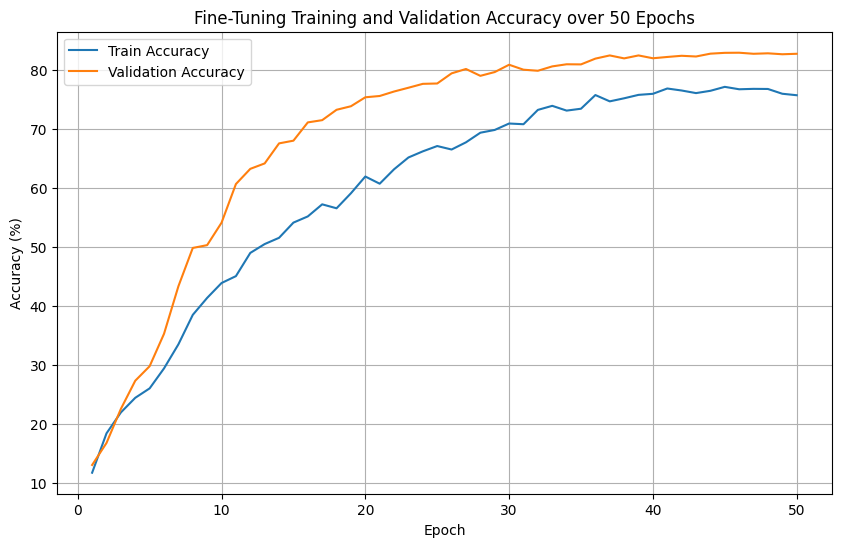

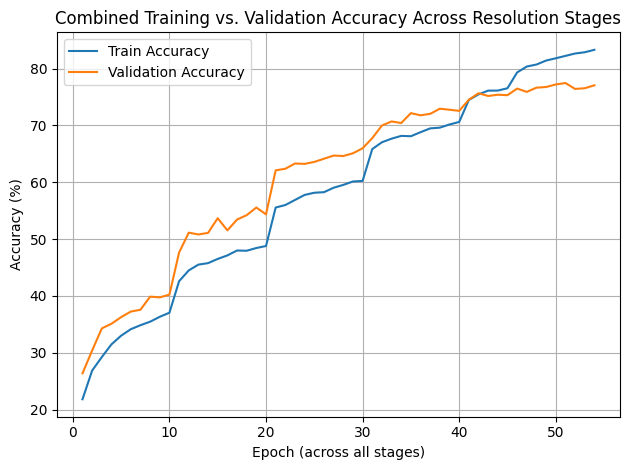

# Student_Training_From_Scratch_Via_Resolution_Curriculum_Learning

**Configuration**  
- Dynamic Input resolution: **12-16-20-24-28-32**  
- Patch size: **2**

---

### Models & Parameters

- **Student (ViT‑student)**  
  - Parameters: 600 000  
  - Curriculum: 10 epochs per resolution stage  
  - 🎯 **Accuracy:** 74.89%


In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from transformers import (
    ViTConfig,
    ViTPreTrainedModel,
    ViTModel,
    get_cosine_schedule_with_warmup
)
from tqdm.auto import tqdm


#Setup & Seeding to be able to reproduce results
#This seed is used for both KD and KD with CL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)

#Tranformation values as found online for CIFAR-10
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)



class SimpleViTStudent(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.vit = ViTModel(config)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values, interpolate_pos_encoding=True)
        logits = self.classifier(outputs.last_hidden_state[:, 0])
        
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            
        return {"logits": logits, "loss": loss}


train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

full = datasets.CIFAR10('./data', train=True, download=True, transform=train_tf)
val_size = int(0.1 * len(full))
train_size = len(full) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    full, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
val_ds.dataset.transform = val_tf

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_ds = datasets.CIFAR10('./data', train=False, transform=val_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#Using Student Class with distillation here - > we used huggingface library but we had to use a smaller ViT model and hence had to implement distill token here

student_config = ViTConfig(
    hidden_size=128,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=256,
    patch_size=2,
    image_size=32,
    num_labels=10
)
student = SimpleViTStudent(student_config).to(device)
if use_dp:
    student = nn.DataParallel(student)


def eval_model(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(pixel_values=imgs)
            preds = outputs["logits"].argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


# Implementing curriculum learning similar to the distillation approach
stages = [(r, 10) for r in [12, 16, 20, 24, 28, 32]]
optimizer = optim.AdamW(student.parameters(), lr=3e-4, weight_decay=1e-4)


for resolution, epochs in stages:
    print(f"\n=== Training at resolution {resolution}px ===")
    
    # Creating resolution-specific transforms
    train_stage_tf = transforms.Compose([
        transforms.RandomCrop(resolution, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    val_stage_tf = transforms.Compose([
        transforms.Resize(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

#
    base_train = datasets.CIFAR10('./data', train=True, download=False, transform=train_stage_tf)
    base_val = datasets.CIFAR10('./data', train=True, download=False, transform=val_stage_tf)
    
    tr_loader = DataLoader(Subset(base_train, train_ds.indices),
                         batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    vl_loader = DataLoader(Subset(base_val, val_ds.indices),
                         batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    best_val_acc = 0
    no_improvement = 0
    patience = 3
#the training part    
    for epoch in range(1, epochs + 1):
        student.train()
        train_correct = train_total = 0
        
        for imgs, labels in tqdm(tr_loader, desc=f"Epoch {epoch}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = student(pixel_values=imgs, labels=labels)
            loss = outputs["loss"]
            
            if loss.dim() > 0:
                loss = loss.mean()
            
            loss.backward()
            optimizer.step()
            
            # Calculating the accuracy
            preds = outputs["logits"].argmax(1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
        
        train_acc = 100 * train_correct / train_total
        val_acc = eval_model(student, vl_loader)
        
        print(f"{resolution}px Ep{epoch}: Train {train_acc:.2f}%  Val {val_acc:.2f}%")
        
        # Save best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improvement = 0
            # Save best model for this resolution stage
            torch.save(student.state_dict(), f'best_student_{resolution}px.pth')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f"→ Early stopping at resolution {resolution}px")
                # Loading the best model for this stage before moving to next resolution
                student.load_state_dict(torch.load(f'best_student_{resolution}px.pth'))
                break
    
    print(f"=> Stage {resolution}px best Val = {best_val_acc:.2f}%")


test_final_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_ds.transform = test_final_tf
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#Saving the model
student.load_state_dict(torch.load('best_student_32px.pth'))
final_test_acc = eval_model(student, test_loader)
print(f"\n🎯 Final Student (CE only) Test Acc: {final_test_acc:.2f}%")

2025-04-21 16:43:07.122453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745253787.377613      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745253787.445028      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


100%|██████████| 170M/170M [00:02<00:00, 77.7MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data

=== Training at resolution 12px ===


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


12px Ep1: Train 22.44%  Val 28.76%


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep2: Train 27.49%  Val 30.68%


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep3: Train 29.83%  Val 31.02%


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep4: Train 30.65%  Val 34.42%


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep5: Train 32.01%  Val 35.10%


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep6: Train 33.08%  Val 36.92%


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep7: Train 33.68%  Val 37.38%


Epoch 8/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep8: Train 34.15%  Val 36.58%


Epoch 9/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep9: Train 34.56%  Val 38.22%


Epoch 10/10:   0%|          | 0/352 [00:00<?, ?it/s]

12px Ep10: Train 35.75%  Val 38.04%
=> Stage 12px best Val = 38.22%

=== Training at resolution 16px ===


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep1: Train 40.37%  Val 42.54%


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep2: Train 41.60%  Val 43.14%


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep3: Train 42.60%  Val 44.96%


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep4: Train 43.38%  Val 45.34%


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep5: Train 43.64%  Val 44.50%


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep6: Train 44.54%  Val 44.94%


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep7: Train 45.17%  Val 47.14%


Epoch 8/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep8: Train 45.27%  Val 47.42%


Epoch 9/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep9: Train 45.97%  Val 46.30%


Epoch 10/10:   0%|          | 0/352 [00:00<?, ?it/s]

16px Ep10: Train 46.72%  Val 47.44%
=> Stage 16px best Val = 47.44%

=== Training at resolution 20px ===


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep1: Train 52.09%  Val 51.66%


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep2: Train 52.74%  Val 52.20%


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep3: Train 53.62%  Val 52.40%


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep4: Train 54.41%  Val 51.78%


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep5: Train 54.94%  Val 52.50%


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep6: Train 55.26%  Val 53.50%


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep7: Train 56.13%  Val 53.16%


Epoch 8/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep8: Train 56.50%  Val 55.00%


Epoch 9/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep9: Train 57.07%  Val 55.42%


Epoch 10/10:   0%|          | 0/352 [00:00<?, ?it/s]

20px Ep10: Train 57.65%  Val 54.84%
=> Stage 20px best Val = 55.42%

=== Training at resolution 24px ===


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep1: Train 62.60%  Val 59.72%


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep2: Train 63.24%  Val 60.98%


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep3: Train 64.03%  Val 61.28%


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep4: Train 64.96%  Val 62.30%


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep5: Train 65.11%  Val 61.36%


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep6: Train 65.48%  Val 61.20%


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

24px Ep7: Train 65.81%  Val 60.90%
→ Early stopping at resolution 24px
=> Stage 24px best Val = 62.30%

=== Training at resolution 28px ===


/tmp/ipykernel_31/1221783128.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(f'best_student_{resolution}px.pth'))


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep1: Train 68.47%  Val 63.24%


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep2: Train 69.08%  Val 65.32%


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep3: Train 69.91%  Val 65.82%


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep4: Train 71.04%  Val 66.54%


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep5: Train 71.17%  Val 66.86%


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep6: Train 71.62%  Val 67.64%


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep7: Train 72.37%  Val 66.22%


Epoch 8/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep8: Train 72.72%  Val 67.12%


Epoch 9/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep9: Train 72.85%  Val 69.68%


Epoch 10/10:   0%|          | 0/352 [00:00<?, ?it/s]

28px Ep10: Train 73.66%  Val 68.70%
=> Stage 28px best Val = 69.68%

=== Training at resolution 32px ===


Epoch 1/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep1: Train 75.91%  Val 72.52%


Epoch 2/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep2: Train 76.98%  Val 72.70%


Epoch 3/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep3: Train 77.22%  Val 72.30%


Epoch 4/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep4: Train 78.07%  Val 73.98%


Epoch 5/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep5: Train 78.31%  Val 73.24%


Epoch 6/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep6: Train 79.18%  Val 73.28%


Epoch 7/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep7: Train 79.32%  Val 74.90%


Epoch 8/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep8: Train 79.70%  Val 73.42%


Epoch 9/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep9: Train 79.87%  Val 73.46%


Epoch 10/10:   0%|          | 0/352 [00:00<?, ?it/s]

32px Ep10: Train 80.44%  Val 74.30%
→ Early stopping at resolution 32px
=> Stage 32px best Val = 74.90%


/tmp/ipykernel_31/1221783128.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load('best_student_32px.pth'))



🎯 Final Student (CE only) Test Acc: 74.89%


# OVERALL TRAINING VS VALIDATION ACCURACY CURVES

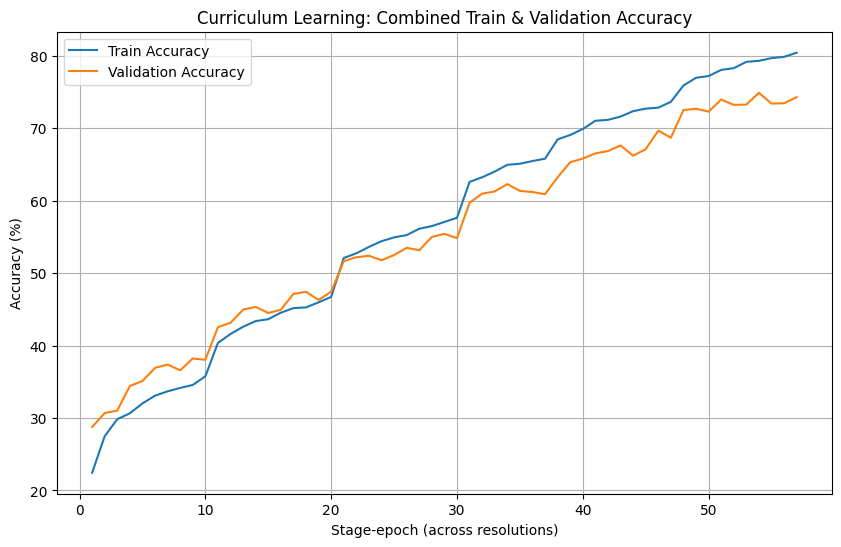

# TRAINING TRAINING VS VALIDATION ACCURACY PER RESOLUTION

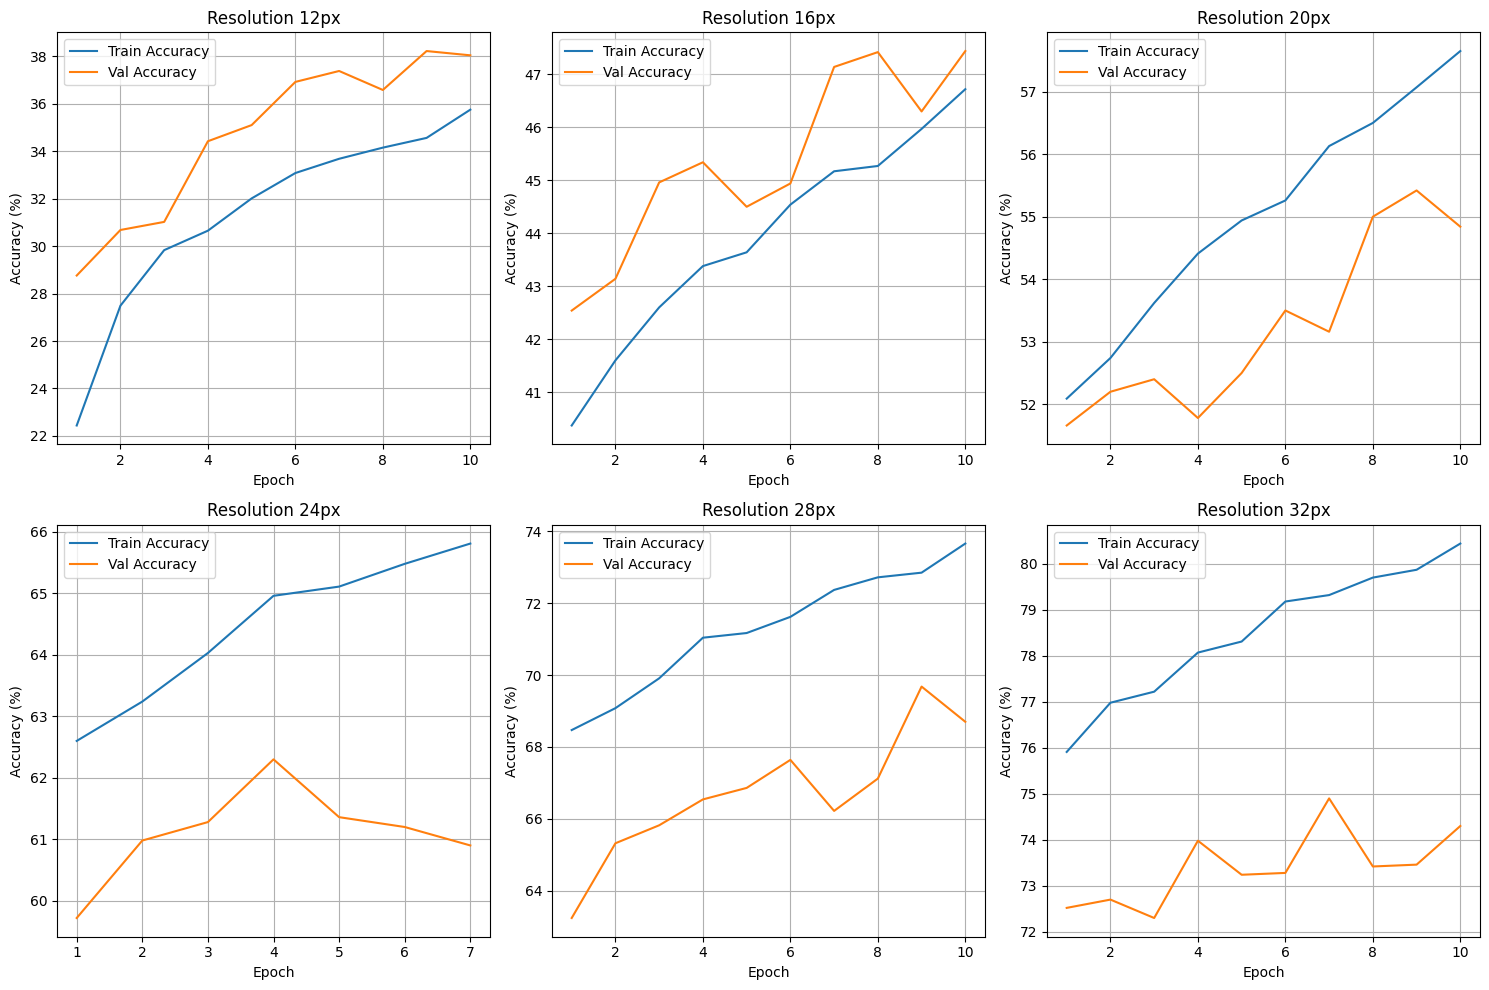

# Student_Training_From_Scratch_Via_CE_Only

**Configuration**  
- Dynamic Input resolution: **12-16-20-24-28-32**  
- Patch size: **2**

---

### Models & Parameters

- **Student (ViT‑student)**  
  - Parameters: 600 000  
  - Curriculum: 10 epochs per resolution stage  
  - 🎯 **Accuracy:** 74.89%


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTConfig, ViTPreTrainedModel, ViTModel
from tqdm.auto import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)

#Tranformation values as found online for CIFAR-10
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

#Creating a Student Class
class SimpleViTStudent(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.vit = ViTModel(config)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values, interpolate_pos_encoding=True)
        logits = self.classifier(outputs.last_hidden_state[:, 0])
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return {"logits": logits, "loss": loss}

# Actually Prwparing the data
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

full = datasets.CIFAR10('./data', train=True, download=True, transform=train_tf)
val_size = int(0.1 * len(full))
train_size = len(full) - val_size
train_ds, val_ds = random_split(
    full, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
val_ds.dataset.transform = val_tf

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

test_ds = datasets.CIFAR10('./data', train=False, transform=val_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#Using Student Class with distillation here - > we used huggingface library but we had to use a smaller ViT model and hence had to implement distill token here

student_config = ViTConfig(
    hidden_size=128,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=256,
    patch_size=2,
    image_size=32,
    num_labels=10
)
student = SimpleViTStudent(student_config).to(device)
if use_dp:
    student = nn.DataParallel(student)

optimizer = optim.AdamW(student.parameters(), lr=3e-4, weight_decay=1e-4)


def eval_model(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(pixel_values=imgs)
            preds = outputs["logits"].argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


epochs = 60
best_val_acc = 0


for epoch in range(1, epochs + 1):
    student.train()
    total_loss = correct = total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = student(pixel_values=imgs, labels=labels)

        loss = outputs["loss"]
        if loss is not None and loss.dim() > 0:
            loss = loss.mean()  # Needed for DataParallel support

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs["logits"].argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    val_acc = eval_model(student, val_loader)

    print(f"Epoch {epoch}: Train Acc {train_acc:.2f}%, Val Acc {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(student.state_dict(), 'best_student_ce_only.pth')

# ---------------------------
# 7. Final Evaluation
# ---------------------------
student.load_state_dict(torch.load('best_student_ce_only.pth'))
final_test_acc = eval_model(student, test_loader)
print(f"\n🎯 Final Student (CE only) Test Acc: {final_test_acc:.2f}%")

2025-04-22 16:16:52.792751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745338613.102934      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745338613.180748      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


100%|██████████| 170M/170M [00:01<00:00, 92.6MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


Epoch 1/60:   0%|          | 0/352 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 1: Train Acc 33.40%, Val Acc 45.46%


Epoch 2/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2: Train Acc 48.49%, Val Acc 51.72%


Epoch 3/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3: Train Acc 54.97%, Val Acc 55.32%


Epoch 4/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4: Train Acc 58.26%, Val Acc 59.18%


Epoch 5/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5: Train Acc 61.30%, Val Acc 60.34%


Epoch 6/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6: Train Acc 63.24%, Val Acc 61.22%


Epoch 7/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7: Train Acc 64.98%, Val Acc 62.18%


Epoch 8/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8: Train Acc 66.16%, Val Acc 63.06%


Epoch 9/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9: Train Acc 67.54%, Val Acc 64.68%


Epoch 10/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10: Train Acc 68.84%, Val Acc 63.08%


Epoch 11/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 11: Train Acc 70.02%, Val Acc 64.98%


Epoch 12/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 12: Train Acc 70.92%, Val Acc 66.74%


Epoch 13/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 13: Train Acc 72.07%, Val Acc 64.18%


Epoch 14/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 14: Train Acc 72.82%, Val Acc 65.62%


Epoch 15/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15: Train Acc 73.77%, Val Acc 66.02%


Epoch 16/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 16: Train Acc 74.54%, Val Acc 66.12%


Epoch 17/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 17: Train Acc 75.55%, Val Acc 66.82%


Epoch 18/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 18: Train Acc 76.55%, Val Acc 66.38%


Epoch 19/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 19: Train Acc 77.30%, Val Acc 67.12%


Epoch 20/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20: Train Acc 78.47%, Val Acc 66.80%


Epoch 21/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 21: Train Acc 79.39%, Val Acc 67.34%


Epoch 22/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 22: Train Acc 80.13%, Val Acc 67.14%


Epoch 23/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 23: Train Acc 81.06%, Val Acc 66.18%


Epoch 24/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 24: Train Acc 82.02%, Val Acc 67.14%


Epoch 25/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25: Train Acc 82.99%, Val Acc 67.32%


Epoch 26/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 26: Train Acc 83.74%, Val Acc 66.86%


Epoch 27/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 27: Train Acc 84.58%, Val Acc 66.22%


Epoch 28/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 28: Train Acc 85.21%, Val Acc 66.52%


Epoch 29/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 29: Train Acc 86.53%, Val Acc 66.72%


Epoch 30/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 30: Train Acc 86.89%, Val Acc 67.16%


Epoch 31/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 31: Train Acc 87.72%, Val Acc 66.78%


Epoch 32/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 32: Train Acc 88.73%, Val Acc 66.76%


Epoch 33/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 33: Train Acc 88.92%, Val Acc 66.50%


Epoch 34/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 34: Train Acc 90.15%, Val Acc 66.70%


Epoch 35/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 35: Train Acc 90.61%, Val Acc 66.46%


Epoch 36/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 36: Train Acc 91.06%, Val Acc 66.50%


Epoch 37/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 37: Train Acc 91.30%, Val Acc 66.76%


Epoch 38/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 38: Train Acc 92.22%, Val Acc 65.94%


Epoch 39/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 39: Train Acc 92.88%, Val Acc 66.30%


Epoch 40/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 40: Train Acc 92.66%, Val Acc 64.94%


Epoch 41/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 41: Train Acc 92.96%, Val Acc 65.92%


Epoch 42/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 42: Train Acc 93.96%, Val Acc 65.74%


Epoch 43/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 43: Train Acc 93.80%, Val Acc 66.60%


Epoch 44/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 44: Train Acc 94.12%, Val Acc 66.28%


Epoch 45/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 45: Train Acc 94.45%, Val Acc 65.80%


Epoch 46/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 46: Train Acc 94.85%, Val Acc 66.56%


Epoch 47/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 47: Train Acc 94.92%, Val Acc 66.14%


Epoch 48/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 48: Train Acc 95.17%, Val Acc 66.72%


Epoch 49/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 49: Train Acc 95.33%, Val Acc 65.84%


Epoch 50/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 50: Train Acc 95.38%, Val Acc 65.20%


Epoch 51/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 51: Train Acc 95.42%, Val Acc 65.38%


Epoch 52/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 52: Train Acc 96.27%, Val Acc 66.32%


Epoch 53/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 53: Train Acc 96.09%, Val Acc 66.18%


Epoch 54/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 54: Train Acc 95.55%, Val Acc 65.42%


Epoch 55/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 55: Train Acc 96.20%, Val Acc 65.54%


Epoch 56/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 56: Train Acc 96.12%, Val Acc 65.70%


Epoch 57/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 57: Train Acc 96.14%, Val Acc 65.74%


Epoch 58/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 58: Train Acc 96.83%, Val Acc 65.80%


Epoch 59/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 59: Train Acc 96.27%, Val Acc 66.36%


Epoch 60/60:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 60: Train Acc 96.54%, Val Acc 66.36%


/tmp/ipykernel_71/970361447.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load('best_student_ce_only.pth'))



🎯 Final Student (CE only) Test Acc: 66.85%


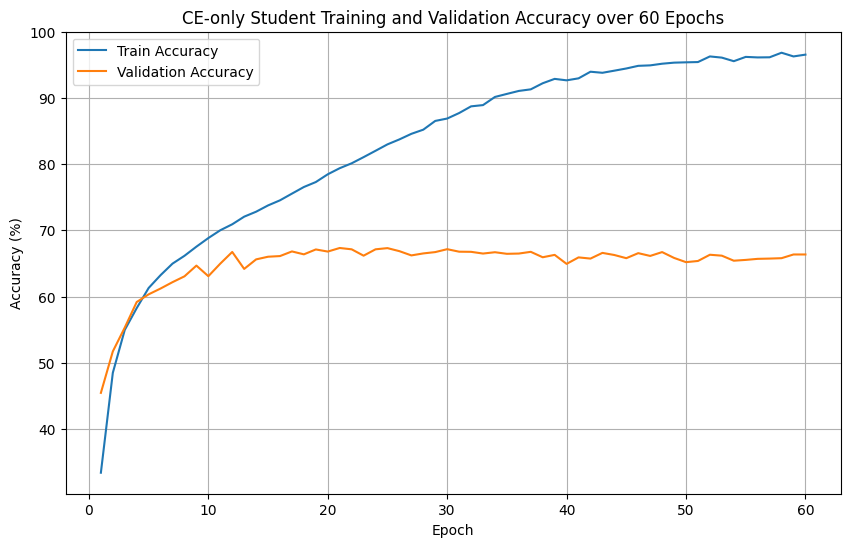

# KD Only (Vit-S used as the Teacher)

**Configuration**  
- Dynamic Input resolution: **32**  
- Patch size: **2**

---

### Models & Parameters

- **Teacher (DeiT‑Small)**  
  - Parameters: 22 000 000  
  - Training: 50 epochs  
  - 🎯 **Accuracy:** 82.95%
    
- **Student (ViT‑student)**  
  - Parameters: 600 000  
  - Curriculum: 10 epochs per resolution stage  
  - 🎯 **Accuracy:** 76.70%


In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomErasing
from transformers import (
    ViTConfig,
    DeiTForImageClassification,
    ViTPreTrainedModel,
    ViTModel,
    get_cosine_schedule_with_warmup
)
from tqdm.auto import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)

#Tranformation values as found online for CIFAR-10

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

#Helping generalize the model via mixup and cutmix

def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, y, y[idx], lam


# Apply cutmix
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0)).to(x.device)
    target_a, target_b = y, y[rand_index]
    W, H = x.size(2), x.size(3)
    cut_ratio = np.sqrt(1.0 - lam)
    cut_w, cut_h = int(W * cut_ratio), int(H * cut_ratio)
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    x_mixed = x.clone()
    x_mixed[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    return x_mixed, target_a, target_b, lam


#Using Student Class with distillation here - > we used huggingface library but we had to use a smaller ViT model and hence had to implement distill token here

class ViTWithDistillation(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.vit = ViTModel(config)
        self.distill_token = nn.Parameter(torch.zeros(1,1,config.hidden_size))
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.distiller  = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, pixel_values, labels=None, teacher_logits=None,
                alpha=0.5, temperature=1.0):
        B = pixel_values.size(0)
        embeds = self.vit.embeddings(pixel_values, interpolate_pos_encoding=True)
        cls_emb   = embeds[:, :1, :]
        patch_emb = embeds[:, 1:, :]
        dist_tok  = self.distill_token.expand(B, -1, -1)
        x = torch.cat([cls_emb, dist_tok, patch_emb], dim=1)
        x = self.vit.encoder(x)[0]
        cls_out, dist_out = x[:,0], x[:,1]
        logits     = self.classifier(cls_out)
        dist_logits= self.distiller(dist_out)

        output = {"logits": logits, "distill_logits": dist_logits}
        if labels is not None and teacher_logits is not None:
            loss_ce = F.cross_entropy(logits, labels)
            loss_kd = F.kl_div(
                F.log_softmax(dist_logits/temperature, dim=1),
                F.softmax(teacher_logits/temperature, dim=1),
                reduction='batchmean'
            ) * (temperature**2)
            output["loss"] = (1-alpha)*loss_ce + alpha*loss_kd
        return output


teacher_config = ViTConfig.from_pretrained(
    'facebook/deit-small-distilled-patch16-224',
    image_size=32,
    patch_size=2,
    num_labels=10,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    stochastic_depth_prob=0.1
)
teacher = DeiTForImageClassification.from_pretrained(
    'facebook/deit-small-distilled-patch16-224',
    config=teacher_config,
    ignore_mismatched_sizes=True
).to(device)
if use_dp:
    teacher = nn.DataParallel(teacher)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

full = datasets.CIFAR10('./data', train=True, download=True, transform=train_tf)
val_size   = int(0.1 * len(full))
train_size = len(full) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    full, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
val_ds.dataset.transform = val_tf



batch_size   = 128
accum_steps  = 2
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

ce_loss     = nn.CrossEntropyLoss(label_smoothing=0.05)
teacher_opt = optim.AdamW(teacher.parameters(), lr=3e-4, weight_decay=2e-4)

epochs       = 65
total_steps  = len(train_loader) * epochs // accum_steps
warmup_steps = int(0.2 * total_steps)
sched        = get_cosine_schedule_with_warmup(teacher_opt, warmup_steps, total_steps)

best_val, no_imp, patience = 0.0, 0, 8

for ep in range(1, epochs+1):
    teacher.train(); tc = tt = 0
    for i, (imgs, labels) in enumerate(tqdm(train_loader, desc=f"Teacher FT {ep}/{epochs}")):
        imgs, labels = imgs.to(device), labels.to(device)
        if np.random.random() < 0.5:
            mixed, y_a, y_b, lam = mixup_data(imgs, labels, alpha=0.2)
        else:
            mixed, y_a, y_b, lam = cutmix_data(imgs, labels, alpha=1.0)
        logits = teacher(pixel_values=mixed, interpolate_pos_encoding=True).logits
        loss   = lam * ce_loss(logits, y_a) + (1-lam) * ce_loss(logits, y_b)
        loss  /= accum_steps
        loss.backward()
        if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
            teacher_opt.step()
            teacher_opt.zero_grad()
            sched.step()
        preds = logits.argmax(1)
        tc   += lam*(preds==y_a).sum().item() + (1-lam)*(preds==y_b).sum().item()
        tt   += labels.size(0)
    train_acc = 100 * tc / tt

    teacher.eval(); vc = vt = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            p = teacher(pixel_values=imgs, interpolate_pos_encoding=True).logits.argmax(1)
            vc += (p==labels).sum().item(); vt += labels.size(0)
    val_acc = 100 * vc / vt

    print(f"FT Ep{ep}: Train {train_acc:.2f}%  Val {val_acc:.2f}%")
    if ep == int(epochs * 0.8):
        for pg in teacher_opt.param_groups:
            pg['lr'] *= 0.1
            print(f"→ Reduced learning rate to {pg['lr']}")
    if val_acc > best_val:
        best_val, no_imp = val_acc, 0
        torch.save(teacher.state_dict(), 'best_teacher.pth')
    else:
        no_imp += 1
        if no_imp >= patience:
            print("→ teacher early stop")
            break

teacher.load_state_dict(torch.load('best_teacher.pth'))
teacher.eval()
for p in teacher.parameters(): p.requires_grad_(False)

test_ds = datasets.CIFAR10('./data', train=False, transform=val_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

def eval_model(model, loader, is_student=False):
    model.eval(); c = t = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            if is_student:
                logits = model(pixel_values=imgs)["logits"]
            else:
                logits = model(pixel_values=imgs, interpolate_pos_encoding=True).logits
            preds = logits.argmax(1)
            c += (preds==labels).sum().item(); t += labels.size(0)
    return 100 * c / t

print(f"\n🎯 Final Teacher Test Acc: {eval_model(teacher, test_loader):.2f}%")

#Using Student Class with distillation here - > we used huggingface library but we had to use a smaller ViT model and hence had to implement distill token here

student_config = ViTConfig(
    hidden_size=128,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=256,
    patch_size=2,
    image_size=32,
    num_labels=10
)
student = ViTWithDistillation(student_config).to(device)
if use_dp:
    student = nn.DataParallel(student)

alpha, temperature = 0.5, 4.0
epochs_student     = 60  

# Single 32×32 data transforms
train_kd_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_kd_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Use same train/val splits
kd_train = datasets.CIFAR10('./data', train=True, download=False, transform=train_kd_tf)
kd_val   = datasets.CIFAR10('./data', train=True, download=False, transform=val_kd_tf)
tr_loader = DataLoader(Subset(kd_train, train_ds.indices),
                       batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
vl_loader = DataLoader(Subset(kd_val,   val_ds.indices),
                       batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

optimizer_s = optim.AdamW(student.parameters(), lr=3e-4, weight_decay=1e-4)
best_kd, no_imp_kd, pat_kd = 0.0, 0, 5

for e in range(1, epochs_student+1):
    student.train(); tc = tt = 0
    for imgs, labels in tqdm(tr_loader, desc=f"Student KD Ep{e}/{epochs_student}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_s.zero_grad()
        teacher_out = teacher(pixel_values=imgs, interpolate_pos_encoding=True).logits
        out = student(pixel_values=imgs, labels=labels,
                      teacher_logits=teacher_out,
                      alpha=alpha, temperature=temperature)
        loss = out["loss"]
        if loss.dim()>0: loss = loss.mean()
        loss.backward(); optimizer_s.step()
        preds = out["logits"].argmax(1)
        tc   += (preds==labels).sum().item(); tt += labels.size(0)
    tr_acc = 100 * tc / tt

    vl_acc = eval_model(student, vl_loader, is_student=True)
    print(f"KD Ep{e}: Train {tr_acc:.2f}%  Val {vl_acc:.2f}%")
    if vl_acc > best_kd:
        best_kd, no_imp_kd = vl_acc, 0
    else:
        no_imp_kd += 1
        if no_imp_kd >= pat_kd:
            print("→ student early stop")
            break

print(f"\n🎯 Final Student Test Acc: {eval_model(student, test_loader, is_student=True):.2f}%")


# THE RESULTS ARE OUTPUT IN ANOTHER NOTEBOOK, WE ARE DISPLAYING THE RESULTS BELOW. 
# WE ARE ALSO RUNNING THIS BASE VERSION ALONGSIDE WITH THE IMPROVEMENT AGAIN ( KD + CL), WE ARE ATTATCHING IMAGES OF THE CODE RUNNING, AS THE CODE WILL TAKE ANOTHER 2.5 HRS TO RUN

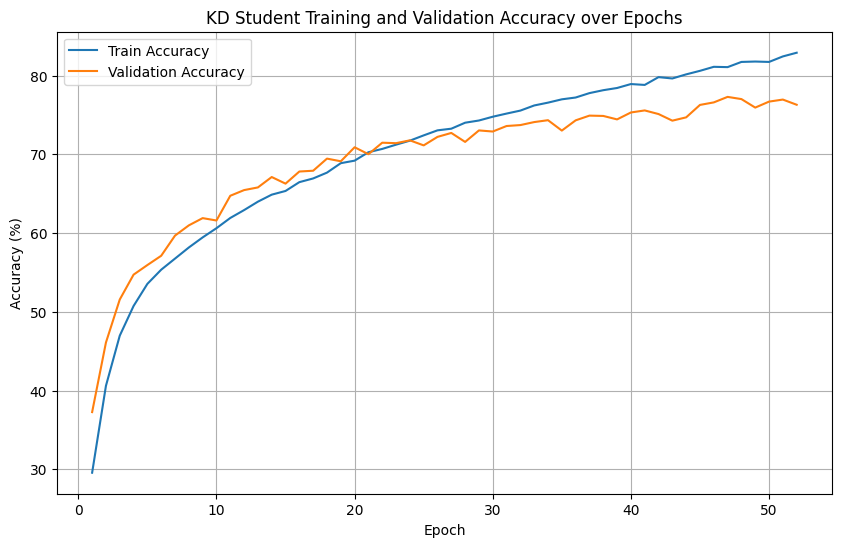

Files already downloaded and verified


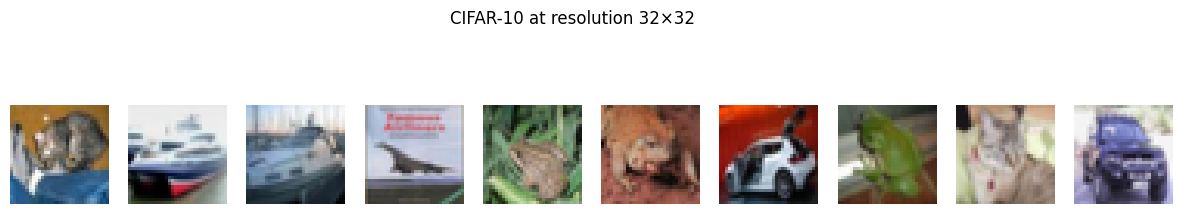

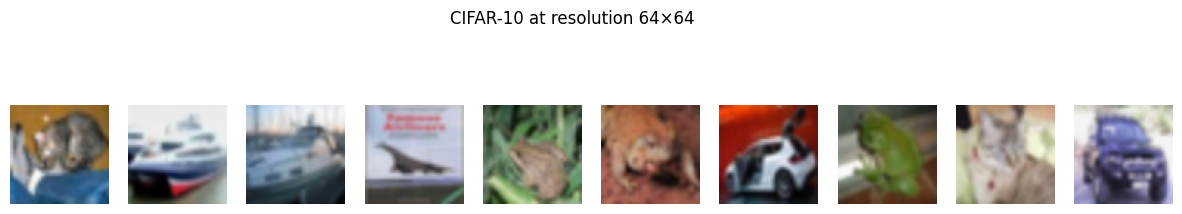

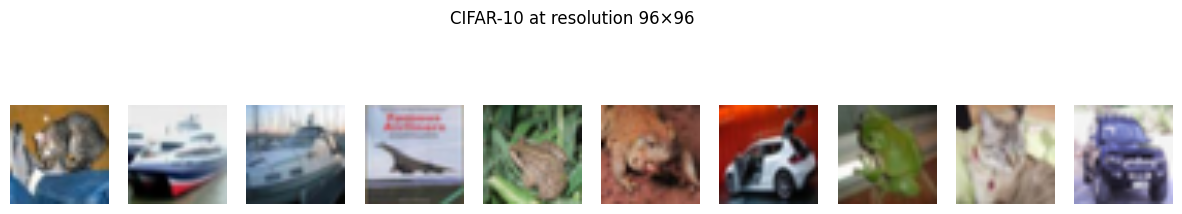

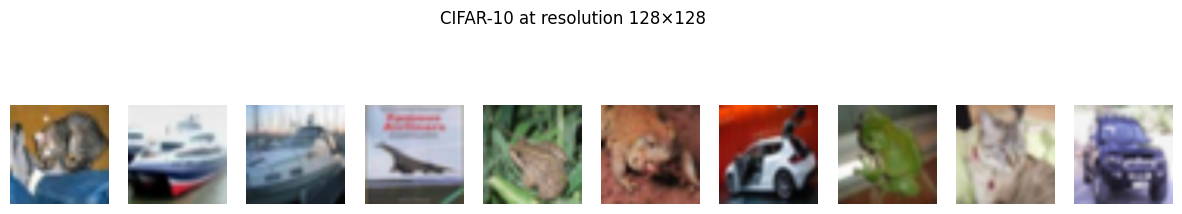

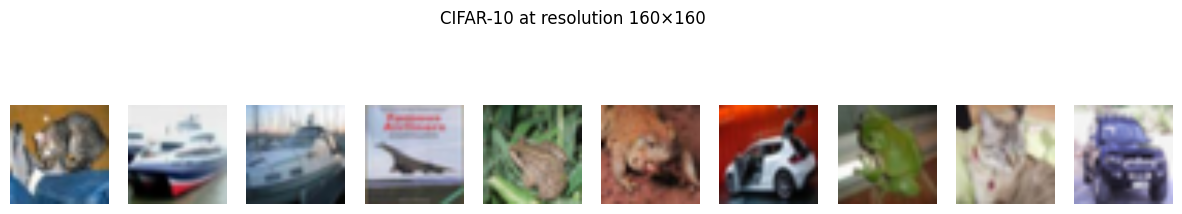

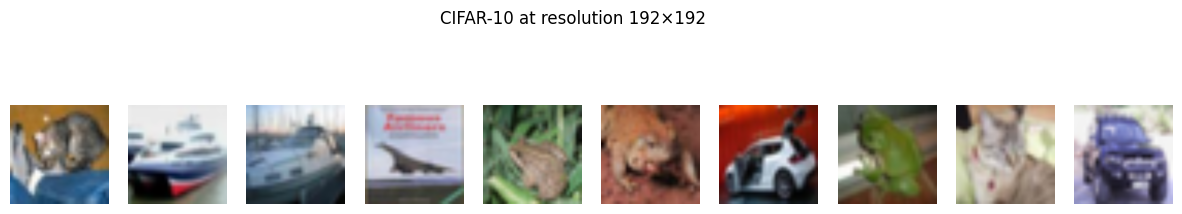

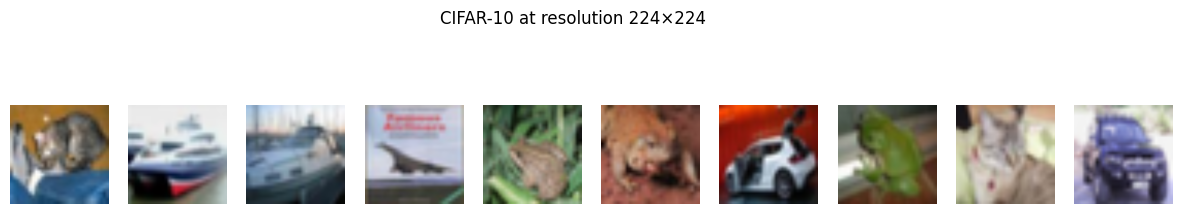

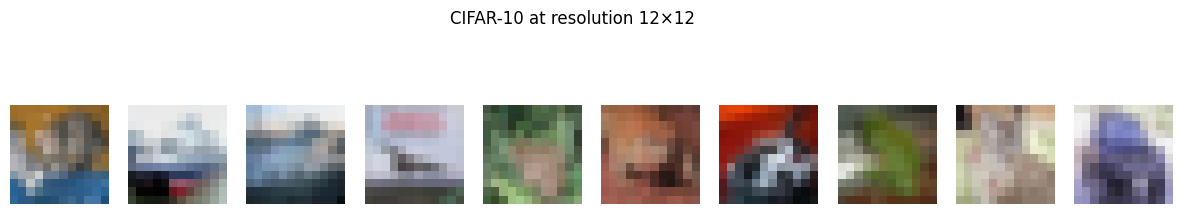

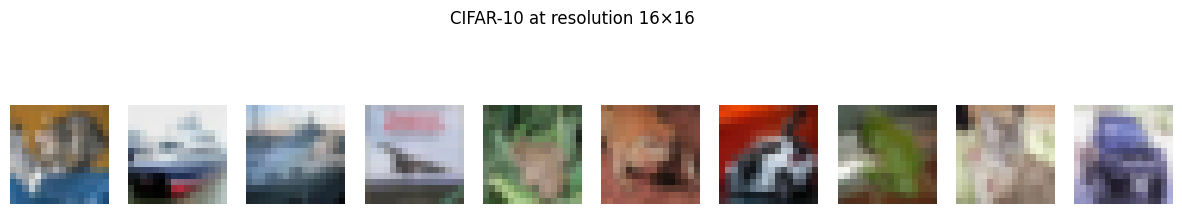

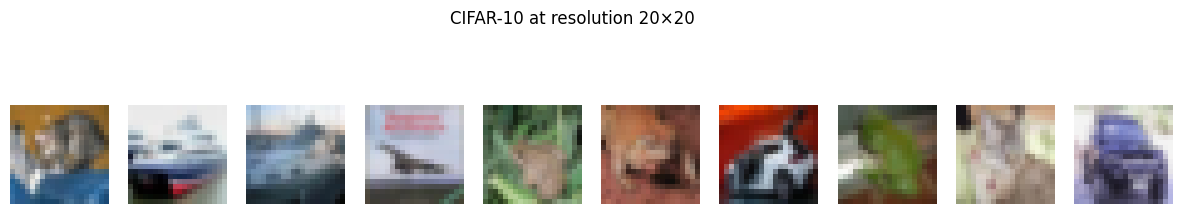

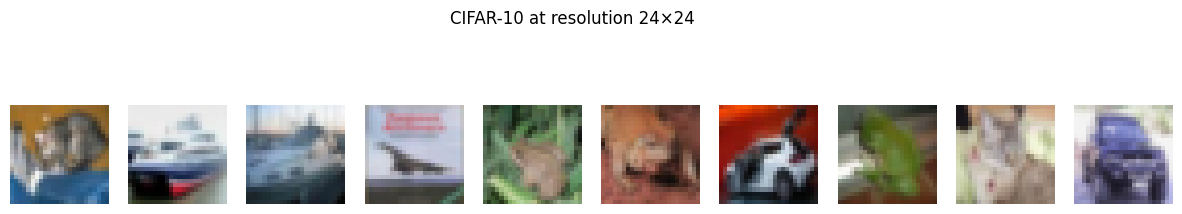

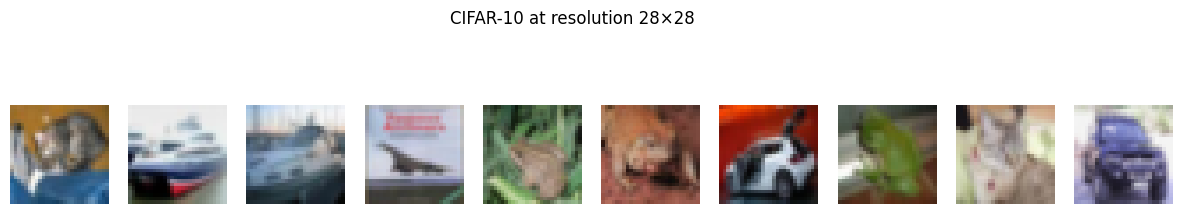

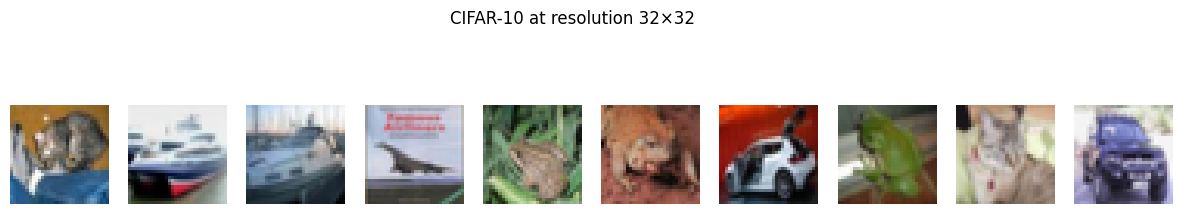

In [15]:
import matplotlib.pyplot as plt

# Load CIFAR-10 test set
dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transforms.ToTensor()
)

# Select first 5 images
images = [dataset[i][0] for i in range(10)]

def display_images_at_resolutions(resolutions, title_prefix):
    for res in resolutions:
        fig, axes = plt.subplots(1, 10, figsize=(15, 3))
        for idx, img in enumerate(images):
            resized = transforms.functional.resize(img, res)
            axes[idx].imshow(resized.permute(1, 2, 0))
            axes[idx].axis('off')
        fig.suptitle(f"{title_prefix} {res}×{res}")
    plt.show()

# Part 1: 5 images each at resolutions 32, 64, 96, 128, 160, 192, 224
res_list1 = list(range(32, 225, 32))
display_images_at_resolutions(res_list1, "CIFAR-10 at resolution")

# Part 2: 5 images each at resolutions 12, 16, 20, 24, 28, 32
res_list2 = list(range(12, 33, 4))
display_images_at_resolutions(res_list2, "CIFAR-10 at resolution")
